# Deep Learning for Satellite Image Classification

## Milestone 5

Pretty much based on Milestone4

* Set up both S2Cloudless and NWPU images
* Augment images using Data Generator.  Number of augmented images is set by AUGMENTATION_SZ
* Train U-Net using original + augmented data and label (masks).  Epoch is set by EPOCHS
* Run prediction and calculate IoU
* See how well the model is predicting (recognizing) water on surface.

Additionally

* Refine label using CRF



In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,  BatchNormalization
from tensorflow.keras.layers import Concatenate, Conv2DTranspose,  Flatten, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import plot_model

from pydensecrf import densecrf
from pydensecrf.utils import unary_from_labels

import pandas as pd

from random import shuffle
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import json, os, glob
import zipfile
import shutil
import rasterio
import datetime
from tqdm import tqdm
%load_ext tensorboard


In [2]:
!rm -rf ./logs/ 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
DATA_DIR = '/home/aki/ManningLiveProjects/2_Data/'
OPTIM_DIR = '/home/aki/ManningLiveProjects/5_Optimizing/'

EPOCHS = 1000
PROD = True

if PROD:
    AUGMENTATION_SZ = 200
    EARLY_STOPPING =50
    GEN_AUG = True
    IOU_SIZE = 100
else:
    AUGMENTATION_SZ = 0 # 200
    EARLY_STOPPING = 2 # 50
    GEN_AUG = False
    IOU_SIZE = 10
    

In [4]:
# Copy S2 images
shutil.rmtree(OPTIM_DIR+'s2cloudless_imagery', ignore_errors=True)
shutil.rmtree(OPTIM_DIR+'s2cloudless_label_imagery', ignore_errors=True)

zipfile.ZipFile(DATA_DIR+'s2cloudless_imagery.zip', 'r').extractall(OPTIM_DIR)
zipfile.ZipFile(DATA_DIR+'s2cloudless_label_imagery.zip','r').extractall(OPTIM_DIR)


In [5]:
# Copy NWPU images
shutil.rmtree(OPTIM_DIR+'nwpu_images', ignore_errors=True)
shutil.rmtree(OPTIM_DIR+'nwpu_label_images', ignore_errors=True)

zipfile.ZipFile(DATA_DIR+'nwpu_images.zip', 'r').extractall(OPTIM_DIR)
zipfile.ZipFile(DATA_DIR+'nwpu_label_images.zip','r').extractall(OPTIM_DIR)

Load multiple VGG-JSON into a dict.  Dict key is the image file name.

In [6]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = tf.keras.backend.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

def mean_iou_3(y_true, y_pred):
    yt0 = y_true.squeeze()
    yp0 = tf.keras.backend.cast(y_pred.squeeze() > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou


In [7]:
checkpointer_unet = tf.keras.callbacks.ModelCheckpoint(filepath='weights/unet.h5', 
                                                       verbose=0, 
                                                       save_best_only=True, 
                                                       save_weights_only=True)
checkpointer_res_unet = tf.keras.callbacks.ModelCheckpoint(filepath='weights/res_unet.h5', 
                                                       verbose=0, 
                                                       save_best_only=True, 
                                                       save_weights_only=True)
checkpointer_res_unet_crf = tf.keras.callbacks.ModelCheckpoint(filepath='weights/res_unet_crf.h5', 
                                                       verbose=0, 
                                                       save_best_only=True, 
                                                       save_weights_only=True)
# checkpointer_s2 = tf.keras.callbacks.ModelCheckpoint(filepath='s2cloudless_unet.h5', 
#                                                      verbose=0, 
#                                                      save_best_only=True, 
#                                                      save_weights_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=EARLY_STOPPING, verbose=1) 

In [8]:
def augment_generators(img_path, label_path):
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            featurewise_center=False,
            featurewise_std_normalization=False,     
            shear_range=0,
            zoom_range=[0.2],
            rotation_range=45,
            horizontal_flip=True)

    img_generator = train_datagen.flow_from_directory(    
            img_path,
            target_size=(2048, 2048), #opt for a fairly small image size for memory efficiency
            batch_size=1,
            class_mode=None, 
            seed=111, 
            shuffle=False)

    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            featurewise_center=False,
            featurewise_std_normalization=False,     
            shear_range=0,
            zoom_range=0.2,
            rotation_range=45,
            horizontal_flip=True)

    mask_generator = test_datagen.flow_from_directory(
            label_path,
            target_size=(2048, 2048),
            batch_size=1,
            class_mode=None, 
            seed=111, 
            shuffle=False)
    return img_generator, mask_generator

def augment_images(img_path, label_path):
    pbar = tqdm(total=AUGMENTATION_SZ)
    counter = 0
    img_gen, mask_gen = augment_generators(img_path, label_path)
    aug_gen = (tuple(np.array(pair, dtype='float64')/255) for pair in zip(img_gen, mask_gen))

    while counter < AUGMENTATION_SZ:
        pbar.update(1)
        x, y = next(aug_gen)
        matplotlib.image.imsave(label_path +"/data/augimage00"+str(counter)+".jpg_mask.jpg", np.squeeze(y[0])) 
        matplotlib.image.imsave(img_path+"/data/augimage00"+str(counter)+".jpg", np.squeeze(x[0]))    
        counter += 1

In [9]:
%%time
if GEN_AUG:
    ! rm -f {OPTIM_DIR+"nwpu_images/data/aug*.jpg"}
    ! rm -f {OPTIM_DIR+"nwpu_label_images/data/aug*.jpg"}
    augment_images(OPTIM_DIR+'nwpu_images', OPTIM_DIR+'nwpu_label_images')

  0%|          | 0/200 [00:00<?, ?it/s]

Found 70 images belonging to 1 classes.
Found 70 images belonging to 1 classes.


100%|██████████| 200/200 [04:22<00:00,  1.31s/it]

CPU times: user 4min 5s, sys: 16.8 s, total: 4min 22s
Wall time: 4min 23s


In [10]:
batch_size = 8
prop_train = 0.6



In [11]:
def crf_labelrefine(input_image, predicted_labels):
    
    compat_spat=10
    compat_col=30
    theta_spat = 20
    theta_col = 80
    num_iter = 7
    num_classes = 2
    
    h, w = input_image.shape[:2] #get image dimensions
    
    d = densecrf.DenseCRF2D(w, h, 2) #create a CRF object

    # For the predictions, densecrf needs 'unary potentials' which are labels (water or no water)
    predicted_unary = unary_from_labels(predicted_labels.astype('int')+1, num_classes, gt_prob= 0.51)
    
    # set the unary potentials to CRF object
    d.setUnaryEnergy(predicted_unary)

    # to add the color-independent term, where features are the locations only:
    d.addPairwiseGaussian(sxy=(theta_spat, theta_spat), compat=compat_spat, kernel=densecrf.DIAG_KERNEL,
                          normalization=densecrf.NORMALIZE_SYMMETRIC)

    input_image_uint = (input_image * 255).astype(np.uint8) #enfore unsigned 8-bit
    # to add the color-dependent term, i.e. 5-dimensional features are (x,y,r,g,b) based on the input image:    
    d.addPairwiseBilateral(sxy=(theta_col, theta_col), srgb=(5, 5, 5), rgbim=input_image_uint,
                           compat=compat_col, kernel=densecrf.DIAG_KERNEL, 
                           normalization=densecrf.NORMALIZE_SYMMETRIC)

    # Finally, we run inference to obtain the refined predictions:
    refined_predictions = np.array(d.inference(num_iter)).reshape(num_classes, h, w)
    
    # since refined_predictions will be a 2 x width x height array, 
    # each slice respresenting probability of each class (water and no water)
    # therefore we return the argmax over the zeroth dimension to return a mask
    return np.argmax(refined_predictions,axis=0)

In [12]:
def image_batch_generator(path, files, mask_threshold, mask_rename, batch_size = 32, with_crf = False, sz = (512, 512)):
  
  while True: # this is here because it will be called repeatedly by the training function
    
    #extract a random subset of files of length "batch_size"
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs (x) and outputs (y)
    batch_x = []
    batch_y = []
    
    #cycle through each image in the batch
    for f in batch:

        #preprocess the raw images 
        rawfile = path+"/data/"+f
        raw = Image.open(rawfile)
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
            raw = np.stack((raw,)*3, axis=-1)

        else:
            raw = raw[:,:,0:3]
            
        #get the image dimensions, find the min dimension, then square the image off    
        nx, ny, nz = np.shape(raw)
        n = np.minimum(nx,ny)
        raw = raw[:n,:n,:] 
            
        batch_x.append(raw)
        
        #get the masks. 
        maskfile = rawfile.replace(mask_rename[0], mask_rename[1])+'_mask.jpg'
        mask = Image.open(maskfile)
        # the mask is 3-dimensional so get the max in each channel to flatten to 2D
        mask = np.max(np.array(mask.resize(sz)),axis=2)
        # water pixels are always greater than 100
        mask = (mask>mask_threshold).astype('int')
        
        # use CRF to refine mask before it is used as a label
        if with_crf:
            mask = crf_labelrefine(raw, mask).squeeze()

        mask = mask[:n,:n]

        batch_y.append(mask)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255. #divide image by 255 to normalize
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3) #add singleton dimension to batch_y

    yield (batch_x, batch_y) #yield both the image and the label together

In [13]:
def get_train_test(batch_size, with_crf=False):
    train_files = os.listdir(OPTIM_DIR+'nwpu_images/data')
    test_files = os.listdir(OPTIM_DIR+'s2cloudless_imagery/data')

    train_generator = image_batch_generator(OPTIM_DIR+'nwpu_images', train_files, 200, 
                                            ['nwpu_images','nwpu_label_images'], 
                                            batch_size=batch_size, with_crf=with_crf)
    test_generator  = image_batch_generator(OPTIM_DIR+'s2cloudless_imagery', test_files, 100, 
                                            ['s2cloudless_imagery','s2cloudless_label_imagery'], 
                                            batch_size=batch_size, with_crf=with_crf)

    train_steps = len(train_files) // batch_size
    test_steps = len(test_files) // batch_size
    
    return train_generator, test_generator, train_steps, test_steps

In [14]:
def unet(sz = (512, 512, 3)):
    inputs = Input(sz)
    _ = inputs
  
    #down sampling 
    f = 8
    layers = []
  
    for i in range(0, 6):
      _ = Conv2D(f, 3, activation='relu', padding='same') (_)
      _ = Conv2D(f, 3, activation='relu', padding='same') (_)
      layers.append(_)
      _ = MaxPooling2D() (_)
      f = f*2
    ff2 = 64 
  
    #bottleneck 
    j = len(layers) - 1
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    _ = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (_)
    _ = Concatenate(axis=3)([_, layers[j]])
    j = j -1 
  
    #upsampling 
    for i in range(0, 5):
      ff2 = ff2//2
      f = f // 2 
      _ = Conv2D(f, 3, activation='relu', padding='same') (_)
      _ = Conv2D(f, 3, activation='relu', padding='same') (_)
      _ = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (_)
      _ = Concatenate(axis=3)([_, layers[j]])
      j = j -1 
    
    #classification 
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    outputs = Conv2D(1, 1, activation='sigmoid') (_)
  
    #model creation 
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
    return model  


In [15]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [16]:
def batchnorm_act(x):
    x = BatchNormalization()(x)
    return Activation("relu")(x)

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = batchnorm_act(x)
    return Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)

def bottleneck_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    bottleneck = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    bottleneck = batchnorm_act(bottleneck)
    
    return Add()([conv, bottleneck])

def res_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    bottleneck = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    bottleneck = batchnorm_act(bottleneck)
    
    return Add()([bottleneck, res])

def upsamp_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    return Concatenate()([u, xskip])

def res_unet_inner(sz, f):
    inputs = Input(sz)
    
    ## downsample  
    e1 = bottleneck_block(inputs, f); f = int(f*2)
    e2 = res_block(e1, f, strides=2); f = int(f*2)
    e3 = res_block(e2, f, strides=2); f = int(f*2)
    e4 = res_block(e3, f, strides=2); f = int(f*2)
    _ = res_block(e4, f, strides=2)
    
    ## bottleneck
    b0 = conv_block(_, f, strides=1)
    _ = conv_block(b0, f, strides=1)
    
    ## upsample
    _ = upsamp_concat_block(_, e4)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e3)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e2)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e1)
    _ = res_block(_, f)
    
    ## classify
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(_)
    
    #model creation 
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

def res_unet(sz, f):
    model = res_unet_inner(sz, f)
    model.compile(optimizer = 'rmsprop', loss = dice_coef_loss, metrics = [dice_coef, mean_iou] )
    print(model.summary)
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    return model
    

In [17]:
def run_unet(tensorboard_callback):
    train_gen, test_gen, train_steps, test_steps = get_train_test(batch_size)
    model = unet()

    model.fit(
        x=train_gen,
        steps_per_epoch = train_steps,
        validation_data = test_gen,
        validation_steps = test_steps,
        batch_size=batch_size,
        epochs=EPOCHS,
        verbose=0,
        use_multiprocessing=False,
        callbacks=[checkpointer_unet, tensorboard_callback, earlystop]
    )

    # Best performing weights are saved by checkpoint
    del model 

In [18]:
def run_res_unet(tensorboard_callback):
    batch_size=2
    train_gen, test_gen, train_steps, test_steps = get_train_test(batch_size)
    model = res_unet((512, 512, 3), 32)

    model.fit(
        x=train_gen,
        steps_per_epoch = train_steps,
        validation_data = test_gen,
        validation_steps = test_steps,
        batch_size=batch_size,
        epochs=EPOCHS,
        verbose=0,
        use_multiprocessing=False,
        callbacks=[checkpointer_res_unet, tensorboard_callback, earlystop]
    )

    # Best performing weights are saved by checkpoint
    del model


In [19]:
def run_res_unet_with_crf(tensorboard_callback):
    batch_size=2
    train_gen, test_gen, train_steps, test_steps = get_train_test(batch_size, True)
    model = res_unet((512, 512, 3), 32)

    model.fit(
        x=train_gen,
        steps_per_epoch = train_steps,
        validation_data = test_gen,
        validation_steps = test_steps,
        batch_size=batch_size,
        epochs=EPOCHS,
        verbose=0,
        use_multiprocessing=False,
        callbacks=[checkpointer_res_unet_crf, tensorboard_callback, earlystop]
    )

    # Best performing weights are saved by checkpoint
    del model

In [20]:
!rm -rf ./logs/ 

In [21]:
log_dir = "logs/unet_fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_res_dir = "logs/unet_res_fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_res_crf_dir = "logs/unet_res_crf_fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# log_dir = ";".join([log_nwpu_dir, log_res_nwpu_dir])
# print(log_dir)

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
tb_res_callback = tf.keras.callbacks.TensorBoard(log_dir=log_res_dir, histogram_freq=1)
tb_res_crf_callback = tf.keras.callbacks.TensorBoard(log_dir=log_res_crf_dir, histogram_freq=1)

%tensorboard --logdir "logs/" --bind_all

Reusing TensorBoard on port 6006 (pid 6958), started 23:57:53 ago. (Use '!kill 6958' to kill it.)

In [22]:
%%time
tf.keras.backend.clear_session()
run_unet(tb_callback)


Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Epoch 00145: early stopping
CPU times: user 1h 39min 6s, sys: 51.6 s, total: 1h 39min 57s
Wall time: 1h 31min 59s


In [23]:
%%time
tf.keras.backend.clear_session()
run_res_unet(tb_res_callback)

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7f5afc744ba8>>
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 00128: early stopping
CPU times: user 2h 29min 11s, sys: 22min 25s, total: 2h 51min 37s
Wall time: 2h 3min 28s


In [24]:
%%time
tf.keras.backend.clear_session()
run_res_unet_with_crf(tb_res_crf_callback)

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7f5a745ee198>>
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 00083: early stopping
CPU times: user 3h 9min 12s, sys: 14min 29s, total: 3h 23min 42s
Wall time: 2h 41min 19s


## Ensemble

Create ensemble of res_unet_crf and res_unet

In [25]:
model_res_unet_crf = res_unet((512, 512, 3), 32)
model_res_unet_crf.compile(optimizer = 'rmsprop', loss = dice_coef_loss, metrics = [dice_coef])
model_res_unet_crf.load_weights('weights/res_unet_crf.h5')

model_res_unet = res_unet((512, 512, 3), 32)
model_res_unet.compile(optimizer = 'rmsprop', loss = dice_coef_loss, metrics = [dice_coef])
model_res_unet.load_weights('weights/res_unet.h5')


<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7f5a34448978>>
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7f5a34045198>>
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [26]:
def predict_with_model_and_score(x, y, model, crf=False):
    #predict the mask 
    pred = model.predict(np.expand_dims(x, 0))
    
    #mask post-processing 
    msk  = pred.squeeze()
    # binarize
    msk[msk >= 0.5] = 1 
    msk[msk < 0.5] = 0
    
    if crf:
        # use CRF to refine mask before it is used as a label
        msk = crf_labelrefine(x.squeeze(), msk).squeeze()
    
    # return the prediction and the IOU score of the prediction
    return msk, mean_iou_3(y, msk)

def predict_with_ensemble_and_score(x, y, model1, model2):
    #predict the mask 
    pred1 = model1.predict(np.expand_dims(x, 0))
    pred2 = model2.predict(np.expand_dims(x, 0))
    
    #mask post-processing 
    msk  = np.maximum(pred1.squeeze(), pred2.squeeze())
    # binarize
    msk[msk >= 0.5] = 1 
    msk[msk < 0.5] = 0
    
    # use CRF to refine mask before it is used as a label
    msk = crf_labelrefine(x.squeeze(), msk).squeeze()
    
    # return the prediction and the IOU score of the prediction
    return msk, mean_iou_3(y, msk)

## Score different models

Get IoU for two models:

* Res-UNet-CRF alone
* Ensemble of Res-Unet-CRF and Res-Unet

IOU_SIZE controls how many IoU to collect.  Can't be more than the number of test fles.

In [27]:
%matplotlib inline


In [28]:
def plot_IoU(IOU):
    print(pd.DataFrame(IOU).describe())
    fliers = dict(markerfacecolor='g', marker='p')
    plt.figure(figsize=(20,8))
    plt.hist(IOU, bins=20)
    plt.xlabel('IOU scores')
    plt.axvline(np.median(IOU), color='r')

 50%|█████     | 100/200 [04:58<04:58,  2.99s/it]


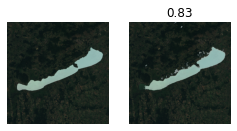

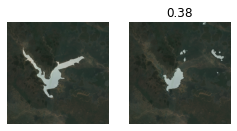

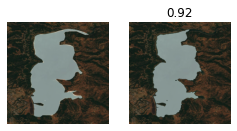

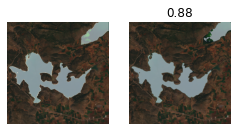

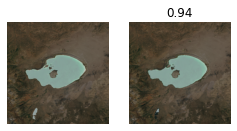

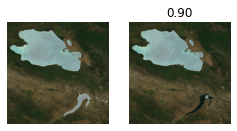

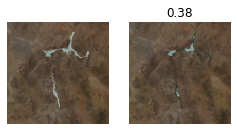

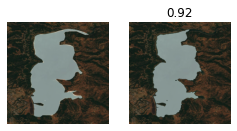

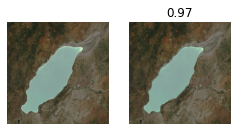

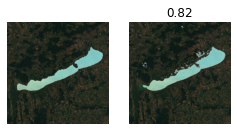

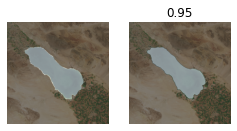

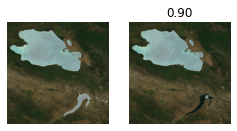

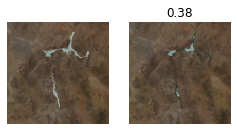

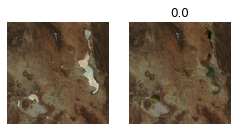

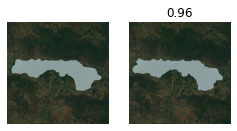

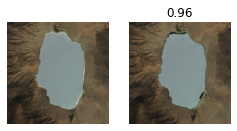

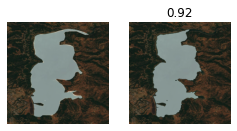

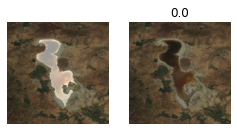

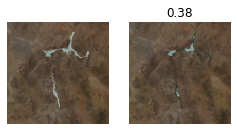

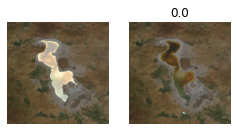

CPU times: user 4min 53s, sys: 6.7 s, total: 5min
Wall time: 5min


In [29]:
%%time
def get_IoU(model):
    _, test_gen, _, _ = get_train_test(batch_size)

    pbar = tqdm(total=AUGMENTATION_SZ)
    IOU = [] #initialize list
    counter = 0 #initialize counter
    while counter < IOU_SIZE: # compare this many images
        x, y = next(test_gen)
        ypred, iou = predict_with_model_and_score(x[0], y[0], model)
        IOU.append(iou.numpy()) #update list

        if counter % 5 == 0: #print every 5th comparison
            pbar.update(5)
            plt.figure(figsize=(4,6))
            plt.subplot(121)
            plt.imshow(x[0])
            plt.imshow(y[0].squeeze(), alpha=0.5, cmap='gray')
            plt.axis('off')

            plt.subplot(122)
            plt.imshow(x[0])
            plt.imshow(ypred.squeeze(), alpha=0.5, cmap='gray')
            plt.title(str(iou.numpy())[:4])
            plt.axis('off')

        counter += 1 #update counter
    return IOU

IoU_res_crf = get_IoU(model_res_unet_crf)
plt.show()

 50%|█████     | 100/200 [05:33<05:33,  3.33s/it]


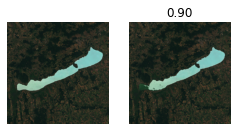

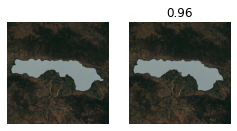

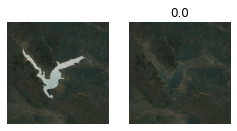

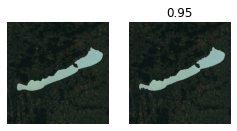

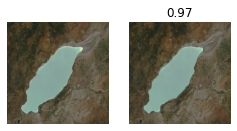

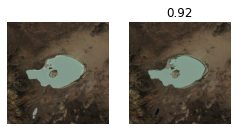

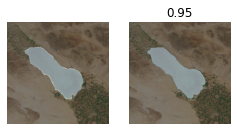

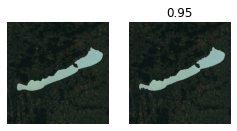

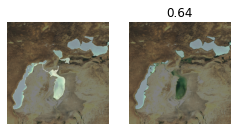

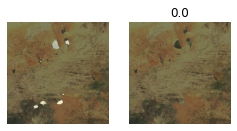

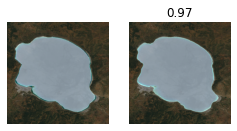

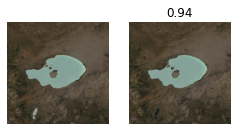

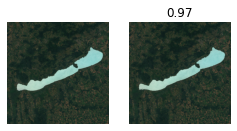

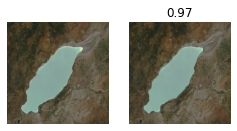

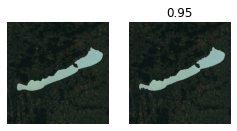

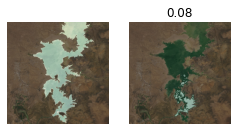

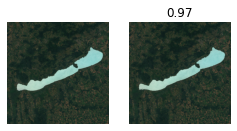

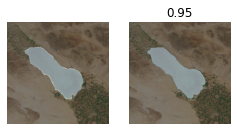

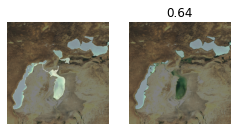

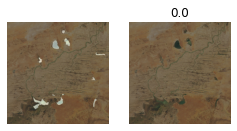

CPU times: user 5min 28s, sys: 7.13 s, total: 5min 35s
Wall time: 5min 35s


In [30]:
%%time
def get_ensemble_IoU(model1, model2):
    _, test_gen, _, _ = get_train_test(batch_size)

    pbar = tqdm(total=AUGMENTATION_SZ)
    IOU = [] #initialize list
    counter = 0 #initialize counter
    while counter < IOU_SIZE: # compare this many images
        x, y = next(test_gen)
        ypred, iou = predict_with_ensemble_and_score(x[0], y[0], model1, model2)
        IOU.append(iou.numpy()) #update list

        if counter % 5 == 0: #print every 5th comparison
            pbar.update(5)
            plt.figure(figsize=(4,6))
            plt.subplot(121)
            plt.imshow(x[0])
            plt.imshow(y[0].squeeze(), alpha=0.5, cmap='gray')
            plt.axis('off')

            plt.subplot(122)
            plt.imshow(x[0])
            plt.imshow(ypred.squeeze(), alpha=0.5, cmap='gray')
            plt.title(str(iou.numpy())[:4])
            plt.axis('off')

        counter += 1 #update counter
    return IOU

IoU_ensemble = get_ensemble_IoU(model_res_unet, model_res_unet_crf)
plt.show()

## View Results

Compare IoU for Res-Unet-CRF  vs Ensemble(Res-Unet-CRF, Res-Unet).   Red line is the mean IoU.

                0
count  100.000000
mean     0.624256
std      0.402440
min      0.000000
25%      0.139763
50%      0.890308
75%      0.961330
max      0.976053


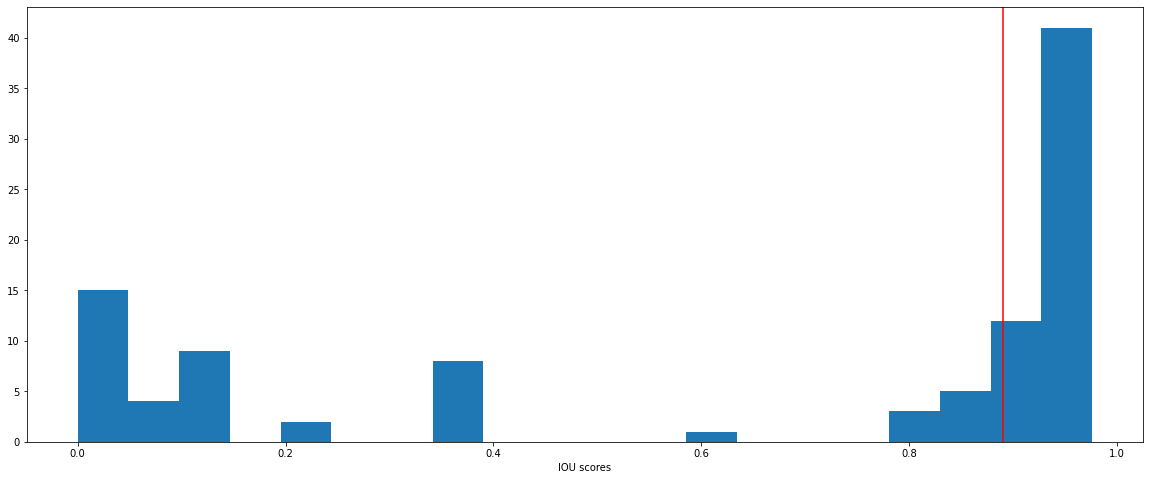

In [31]:
plot_IoU(IoU_res_crf)

                0
count  100.000000
mean     0.644380
std      0.417777
min      0.000000
25%      0.081391
50%      0.902559
75%      0.958876
max      0.979301


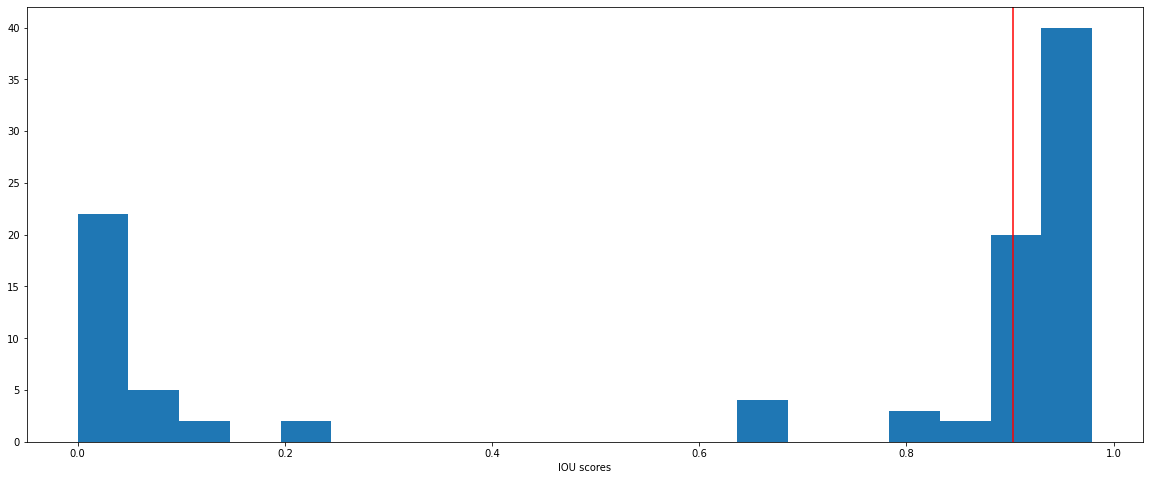

In [32]:
plot_IoU(IoU_ensemble)

Surprisingly, ensemble actually does better than Res-Unet-CRF alone.


In [33]:
def plot_mask_prediction(files, path, label_path, model):
    plt.axis('off')
    picked_file = np.random.choice(files)
    infile = path + "/data/" + picked_file
    raw = Image.open(infile)
    raw = np.array(raw.resize((512, 512)))/255.
    
    ground_truth_file = label_path + "/data/" + picked_file + "_mask.jpg"
    ground_truth_raw = Image.open(ground_truth_file)
    ground_truth_raw = np.array( ground_truth_raw.resize( (512, 512) ) ) / 255.0
    ground_truth_raw = np.max(np.array(ground_truth_raw),axis=2)
    
    ground_truth_raw = (ground_truth_raw>0.5).astype('int')
    ground_truth_raw = np.stack((ground_truth_raw,)*3, axis=-1)  # turn into RGB

    #predict the mask 
    pred = 255 * model.predict(np.expand_dims(raw, 0)).squeeze()
    del model
    
    #mask post-processing 
    predicted_msk  = (pred > 200).astype('int') #100       
    predicted_msk = np.stack((predicted_msk,)*3, axis=-1)  # turn into RGB
    
    meanIoU = tf.keras.metrics.MeanIoU(num_classes=2)
    meanIoU.update_state(predicted_msk, ground_truth_raw)
    print(meanIoU.result().numpy())    

    #show the mask and the segmented image 
    combined = np.concatenate([raw, 
                               predicted_msk, 
                               ground_truth_raw, 
                               predicted_msk - ground_truth_raw ], 
                              axis = 1)
    plt.imshow(combined)
    plt.show()
    
    
